# Dogs Vs. Cats: Training a Covnet Using a Pretrained Model 

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
# In order to download from Kaggle, we need to provide our authenticaion JSON file. 

from google.colab import files
files.upload()

In [4]:
# Create the directory that Kaggle checks for the authentication key, move the JSON file to the proper location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions on the key
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [5]:
# Download the dataset from Kaggle, then unzip it. 
!kaggle competitions download -c dogs-vs-cats
# Note that Google Colab uses an outdated Kaggle API (1.5.4) so the file downloaded is different.
!unzip -q train.zip
!rm train.zip

 99% 269M/271M [00:01<00:00, 142MB/s]
100% 271M/271M [00:01<00:00, 165MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 79.0MB/s]
 96% 523M/543M [00:02<00:00, 267MB/s]
100% 543M/543M [00:02<00:00, 255MB/s]


In [6]:
# Move the dataset to its own directory
!mkdir dogs-vs-cats-data
!cp -r train dogs-vs-cats-data

In [7]:
import os
import shutil
import pathlib

# Our full data set is in the original data folder. Let's make a new small folder.
original_dir = pathlib.Path('dogs-vs-cats-data')
new_base_dir = pathlib.Path('dogs-vs-cats-small')

# Define a function to move our images to the new directory.
def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
        # images in the train set have the file name dog.5.jpg, with no leading zeros. 
        fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
        for fname in fnames:
            # Copy from original_dir to new_base_dir
            shutil.copyfile(src=original_dir / "train"/ fname, dst=dir / fname)

# # Define size of each set
# # Select size/2 of each type of image to chose for the small subset. 
# num_train_images = 2000
# num_val_images = 1000
# num_test_images = 2000

# Use Full Dataset
num_train_images = 10000
num_val_images = 5000
num_test_images = 10000

# Loop over the train, validation, and test sets, making subsets for each.
i = 0
for dataset, num_images in {"train":num_train_images, "validation":num_val_images, "test":num_test_images}.items():
    make_subset(dataset, i, int(i + num_images/2))
    i += int(num_images / 2)

In [8]:
# Create datasets from images
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    labels='inferred',
    image_size=(250, 250),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    labels='inferred',
    image_size=(250, 250),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    labels='inferred',
    image_size=(250, 250),
    batch_size=32)

Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


In [9]:
# Import the VGG16 Model
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(250, 250, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

In [11]:
# Freeze the VGG16 model by setting the trainable attribute to False.
conv_base  = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False

In [12]:
# Create data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

In [13]:
# Build the model
inputs = keras.Input(shape=(250, 250, 3))
x = data_augmentation(inputs)

x = conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [14]:
# Define the callbacks and save the best model to a new file
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='models/full_model.keras',
    save_best_only=True,
    monitor='val_loss')]

In [15]:
import time
# Time the time it takes to train the model
start_time = time.time()

history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/50
313/313 [==============================] - 149s 349ms/step - loss: 30.5399 - accuracy: 0.8813 - val_loss: 5.3307 - val_accuracy: 0.9650
Epoch 2/50
313/313 [==============================] - 103s 329ms/step - loss: 8.2858 - accuracy: 0.9369 - val_loss: 5.4000 - val_accuracy: 0.9550
Epoch 3/50
313/313 [==============================] - 103s 330ms/step - loss: 3.5285 - accuracy: 0.9507 - val_loss: 1.4007 - val_accuracy: 0.9662
Epoch 4/50
313/313 [==============================] - 103s 330ms/step - loss: 1.4744 - accuracy: 0.9467 - val_loss: 2.9532 - val_accuracy: 0.9274
Epoch 5/50
313/313 [==============================] - 104s 330ms/step - loss: 1.3043 - accuracy: 0.9452 - val_loss: 1.1690 - val_accuracy: 0.9634
Epoch 6/50
313/313 [==============================] - 103s 330ms/step - loss: 0.9844 - accuracy: 0.9531 - val_loss: 0.7909 - val_accuracy: 0.9726
Epoch 7/50
313/313 [==============================] - 104s 331ms/step - loss: 1.1402 - accuracy: 0.9474 - val_loss: 1.8271 

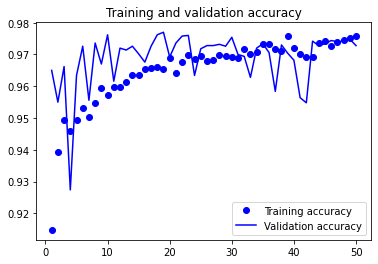

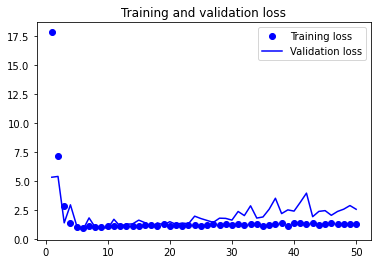

In [16]:
# Plot the loss and accuracy of the model over the training and validation data during training. 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
# Display the accuracy of the model on the test dataset
model = keras.models.load_model('models/full_model.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

313/313 [==============================] - 69s 220ms/step - loss: 0.9658 - accuracy: 0.9728
Test accuracy: 0.973


In [18]:
# Download the model files
files.download('models/full_model.keras') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fine Tuning a Pretrained Model

In [19]:
# Unfreeze the top four layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [20]:
# Recompile the model (since we changed the trainable layers)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])


In [21]:
# Define callbacks again, with a new save file
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='models/full_model_with_fine_tuning.keras',
    save_best_only=True,
    monitor='val_loss')]


In [22]:
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/50
313/313 [==============================] - 105s 332ms/step - loss: 0.8992 - accuracy: 0.9577 - val_loss: 0.6424 - val_accuracy: 0.9760
Epoch 2/50
313/313 [==============================] - 104s 331ms/step - loss: 0.6974 - accuracy: 0.9625 - val_loss: 0.6042 - val_accuracy: 0.9764
Epoch 3/50
313/313 [==============================] - 104s 331ms/step - loss: 0.6496 - accuracy: 0.9643 - val_loss: 0.5722 - val_accuracy: 0.9764
Epoch 4/50
313/313 [==============================] - 104s 331ms/step - loss: 0.6809 - accuracy: 0.9642 - val_loss: 0.5449 - val_accuracy: 0.9756
Epoch 5/50
313/313 [==============================] - 104s 332ms/step - loss: 0.6841 - accuracy: 0.9633 - val_loss: 0.5270 - val_accuracy: 0.9758
Epoch 6/50
313/313 [==============================] - 104s 331ms/step - loss: 0.5676 - accuracy: 0.9658 - val_loss: 0.4960 - val_accuracy: 0.9762
Epoch 7/50
313/313 [==============================] - 104s 332ms/step - loss: 0.5879 - accuracy: 0.9620 - val_loss: 0.4806 -

In [23]:
# Display the accuracy of the model on the test dataset
model = keras.models.load_model('models/full_model_with_fine_tuning.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

313/313 [==============================] - 73s 232ms/step - loss: 0.0922 - accuracy: 0.9752
Test accuracy: 0.975


In [24]:
# Download the model files
files.download('models/full_model_with_fine_tuning.keras') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>